## Reading Data from the STAC API

The Planetary Computer catalogs the datasets we host using the [STAC](http://stacspec.org/) (SpatiaoTemporal Asset Catalog) specification. We provide a [STAC API](https://github.com/radiantearth/stac-api-spec) endpoint that can be used to search our datasets by space, time, and more. This quickstart will show you how to search for data using our STAC API and open-source Python libraries. For more on how to use our STAC API from R, see [Reading data from the STAC API with R](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac-r/).

To get started you'll need the [pystac-client](https://github.com/stac-utils/pystac-client) library installed. You can install it via pip:

```
> pip install pystac-client
```

First we'll use pystac-client to open up our STAC API:

In [1]:
from pystac_client import Client

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

### Searching

We can use the STAC API to search for assets meeting some criteria. This might include the date and time the asset covers, is spatial extent, or any other property captured in the STAC item's metadata.

In this example we'll search for imagery from [Landsat Collection 2 Level-2](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2) area around Microsoft's main campus in December of 2020.

In [2]:
time_range = "2020-12-01/2020-12-31"
bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = catalog.search(collections=["landsat-8-c2-l2"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

4

In that example our spatial query used a bounding box with a `bbox`. Alternatively, you can pass a GeoJSON object as `intersects`

```python
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.2751, 47.5469],
            [-121.9613, 47.9613],
            [-121.9613, 47.9613],
            [-122.2751, 47.9613],
            [-122.2751, 47.5469],
        ]
    ],
}

time_range = "2020-12-01/2020-12-31"

search = catalog.search(
    collections=["landsat-8-c2-l2"], intersects=area_of_interest, datetime=time_range
)
```

`items` is a [`pystac.ItemCollection`](https://pystac.readthedocs.io/en/stable/api/item_collection.html#pystac-item-collection). We can see that 4 items matched our search criteria.

In [3]:
len(items)

4

Each [`pystac.Item`](https://pystac.readthedocs.io/en/stable/api/pystac.html#pystac.Item) in this `ItemCollection` includes all the metadata for that scene. [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) are GeoJSON features, and so can be loaded by libraries like [geopandas](http://geopandas.readthedocs.io/).

In [4]:
import geopandas

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

,geometry,datetime,platform,proj:bbox,proj:epsg,description,instruments,eo:cloud_cover,view:off_nadir,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,view:sun_elevation,landsat:cloud_cover_land,landsat:processing_level,landsat:collection_number,landsat:collection_category
0,"POLYGON ((-122.74802 48.51223, -120.22983 48.0...",2020-12-29T18:55:56.738265Z,landsat-8,"[471585.0, 5136885.0, 705015.0, 5373315.0]",32610,Landsat Collection 2 Level-2 Surface Reflectan...,"[oli, tirs]",100.00,0,027,LC80460272020364LGN00,046,2,162.253231,17.458298,100.00,L2SP,02,T2
1,"POLYGON ((-124.29833 48.51325, -121.79248 48.0...",2020-12-20T19:02:09.878796Z,landsat-8,"[353385.0, 5135085.0, 589215.0, 5374215.0]",32610,Landsat Collection 2 Level-2 Surface Reflectan...,"[oli, tirs]",100.00,0,027,LC80470272020355LGN00,047,2,163.360118,17.414441,100.00,L2SP,02,T2
2,"POLYGON ((-122.75189 48.51190, -120.23406 48.0...",2020-12-13T18:56:00.096447Z,landsat-8,"[471285.0, 5136885.0, 704715.0, 5373315.0]",32610,Landsat Collection 2 Level-2 Surface Reflectan...,"[oli, tirs]",98.73,0,027,LC80460272020348LGN00,046,2,164.126188,17.799744,98.64,L2SP,02,T2
3,"POLYGON ((-124.29534 48.51347, -121.78981 48.0...",2020-12-04T19:02:11.194486Z,landsat-8,"[353685.0, 5135085.0, 589515.0, 5374215.0]",32610,Landsat Collection 2 Level-2 Surface Reflectan...,"[oli, tirs]",1.55,0,027,LC80470272020339LGN00,047,2,164.914060,18.807230,1.90,L2SP,02,T1


We can use the `eo` extension to sort the items by cloudiness. We'll grab an item with low cloudiness:

In [5]:
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
selected_item

<Item id=LC08_L2SP_047027_20201204_02_T1>

Each STAC item has one or more [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object), which include links to the actual files.

In [6]:
import rich.table

table = rich.table.Table("Asset Key", "Descripiption")
for asset_key, asset in selected_item.assets.items():
    # print(f"{asset_key:<25} - {asset.title}")
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key                 ┃ Descripiption                                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ANG                       │ Angle Coefficients File                        │
│ SR_B1                     │ Coastal/Aerosol Band (B1)                      │
│ SR_B2                     │ Blue Band (B2)                                 │
│ SR_B3                     │ Green Band (B3)                                │
│ SR_B4                     │ Red Band (B4)                                  │
│ SR_B5                     │ Near Infrared Band 0.8 (B5)                    │
│ SR_B6                     │ Short-wave Infrared Band 1.6 (B6)              │
│ SR_B7                     │ Short-wave Infrared Band 2.2 (B7)              │
│ ST_QA                     │ Surface Temperature Quality Assessment Band    │
│ ST_B10                    │ Surface Temperature Band (B10)                 │
│ MTL.txt                   │ Product Metadata File                          │
│ MTL.xml                   │ Product Metadata File (xml)                    │
│ ST_DRAD                   │ Downwelled Radiance Band                       │
│ ST_EMIS                   │ Emissivity Band                                │
│ ST_EMSD                   │ Emissivity Standard Deviation Band             │
│ ST_TRAD                   │ Thermal Radiance Band                          │
│ ST_URAD                   │ Upwelled Radiance Band                         │
│ MTL.json                  │ Product Metadata File (json)                   │
│ QA_PIXEL                  │ Pixel Quality Assessment Band                  │
│ ST_ATRAN                  │ Atmospheric Transmittance Band                 │
│ ST_CDIST                  │ Cloud Distance Band                            │
│ QA_RADSAT                 │ Radiometric Saturation Quality Assessment Band │
│ thumbnail                 │ Thumbnail image                                │
│ SR_QA_AEROSOL             │ Aerosol Quality Analysis Band                  │
│ reduced_resolution_browse │ Reduced resolution browse image                │
│ tilejson                  │ TileJSON with default rendering                │
│ rendered_preview          │ Rendered preview                               │
└───────────────────────────┴────────────────────────────────────────────────┘

Here, we'll inspect the `rendered_preview` asset.

In [7]:
selected_item.assets["rendered_preview"].to_dict()

{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=landsat-8-c2-l2&item=LC08_L2SP_047027_20201204_02_T1&assets=SR_B4&assets=SR_B3&assets=SR_B2&color_formula=gamma+RGB+2.7%2C+saturation+1.5%2C+sigmoidal+RGB+15+0.55',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

In [8]:
from IPython.display import Image

Image(url=selected_item.assets["rendered_preview"].href, width=500)

That `rendered_preview` asset is generated dynamically from the raw data using the Planetary Computer's [data API](http://planetarycomputer.microsoft.com/api/data/v1/). We can access the raw data, stored as Cloud Optimzied GeoTIFFs in Azure Blob Storage, using one of the other assets. That said, we do need to do one more thing before accessing the data. If we simply made a request to the file in blob storage we'd get a 404:

In [9]:
import requests

url = selected_item.assets["SR_B2"].href
print("Accessing", url)
response = requests.get(url)
response

Accessing https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2020/047/027/LC08_L2SP_047027_20201204_20210313_02_T1/LC08_L2SP_047027_20201204_20210313_02_T1_SR_B2.TIF


<Response [404]>

That's because the Plantary Computer uses Azure Blob Storage [SAS Tokens](https://docs.microsoft.com/en-us/azure/storage/common/storage-sas-overview#how-a-shared-access-signature-works) to enable access to our data, which allows us to provide the data for free to anyone, anywhere while maintaining some control over the amount of egress for datasets.

To get a token for access, you can use the Planetary Computer's [Data Authentication API](../reference/sas.md). You can access that anonymously, or you can provide an API Key for higher rate limits and longer-lived tokens.

You can also use the [planetary-computer](https://github.com/microsoft/planetary-computer-sdk-for-python) package to generate tokens and sign asset HREFs for access. You can install via pip with

```
> pip install planetary-computer
```

In [10]:
import planetary_computer

# PC_SDK_SUBSCRIPTION_KEY
signed_href = planetary_computer.sign(selected_item).assets["SR_B2"].href

We can load up that single COG using libraries like [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html) or [rasterio](https://rasterio.readthedocs.io/en/latest/)

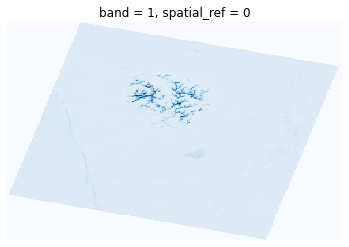

In [11]:
# import xarray as xr
import rioxarray

ds = rioxarray.open_rasterio(signed_href, overview_level=4).squeeze()
img = ds.plot(cmap="Blues", add_colorbar=False)
img.axes.set_axis_off();

If you wish to work with multiple STAC items as a datacube, you can use libraries like [stackstac](https://stackstac.readthedocs.io/) or [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html).

In [12]:
import stackstac

ds = stackstac.stack(planetary_computer.sign(items))
ds

,Array,Chunk
Bytes,52.91 GiB,8.00 MiB
Shape,"(4, 19, 7972, 11722)","(1, 1, 1024, 1024)"
Count,7448 Tasks,7296 Chunks
Type,float64,numpy.ndarray


### Searching on additional properties

Previously, we searched for items by space and time. Because the Planetary Computer's STAC API supports the [query](https://github.com/radiantearth/stac-api-spec/blob/master/fragments/query/README.md) parameter, you can search on additional properties on the STAC item.

For example, collections like `sentinel-2-l2a` and `landsat-8-c2-l2` both implement the [`eo` STAC extension](https://github.com/stac-extensions/eo) and include an `eo:cloud_cover` property. Use `query={"eo:cloud_cover": {"lt": 20}}` to return only items that are less than 20% cloudy.

In [13]:
time_range = "2020-12-01/2020-12-31"
bbox = [-122.2751, 47.5469, -121.9613, 47.7458]

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 20}},
)
items = search.get_all_items()

Other common uses of the `query` parameter is to filter a collection down to items of a specific type, For example, the [GOES-CMI](https://planetarycomputer.microsoft.com/dataset/goes-cmi) collection includes images from various when the satellite is in various modes, which produces images of either the Full Disk of the earth, the continental United States, or a mesoscale. You can use `goes:image-type` to filter down to just the ones you want.

In [14]:
search = catalog.search(
    collections=["goes-cmi"],
    bbox=[-67.2729, 25.6000, -61.7999, 27.5423],
    datetime=["2018-09-11T13:00:00Z", "2018-09-11T15:40:00Z"],
    query={"goes:image-type": {"eq": "MESOSCALE"}},
)

### Analyzing STAC Metadata

STAC items are proper GeoJSON Features, and so can be treated as a kind of data on their own.

In [15]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[-124.2751, 45.5469, -110.9613, 47.7458],
    datetime="2020-12-26/2020-12-31",
)
items = search.get_all_items()

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

df[["geometry", "datetime", "s2:mgrs_tile", "eo:cloud_cover"]].explore(
    column="eo:cloud_cover", style_kwds={"fillOpacity": 0.1}
)

Or we can plot cloudiness of a region over time.

In [16]:
import pandas as pd

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=[-124.2751, 45.5469, -123.9613, 45.7458],
    datetime="2020-01-01/2020-12-31",
)
items = search.get_all_items()
df = geopandas.GeoDataFrame.from_features(items.to_dict())
df["datetime"] = pd.to_datetime(df["datetime"])

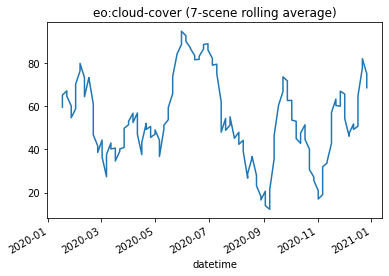

In [17]:
ts = df.set_index("datetime").sort_index()["eo:cloud_cover"].rolling(7).mean()
ts.plot(title="eo:cloud-cover (7-scene rolling average)");

### Working with STAC Catalogs and Collections

Our `catalog` is a [STAC Catalog](https://github.com/radiantearth/stac-spec/blob/master/catalog-spec/catalog-spec.md) that we can crawl or search. The Catalog contains [STAC Collections](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md) for each dataset we have indexed (which is not the yet the entirity of data hosted by the Planetary Computer).

Collections have information about the [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) they contain. For instance, here we look at the [Bands](https://github.com/stac-extensions/eo#band-object) available for [Landsat 8 Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-8-c2-l2) data:

In [18]:
import pandas as pd

landsat = catalog.get_collection("landsat-8-c2-l2")

pd.DataFrame(landsat.extra_fields["summaries"]["eo:bands"])

,gsd,name,common_name,description,center_wavelength,full_width_half_max
0,30,SR_B1,coastal,coastal,0.44,0.02
1,30,SR_B2,blue,visible blue,0.48,0.06
2,30,SR_B3,green,visible green,0.56,0.06
3,30,SR_B4,red,visible red,0.65,0.04
4,30,SR_B5,nir,near-infrared,0.86,0.03
5,30,SR_B6,swir16,short-wave infrared,1.60,0.08
6,30,SR_B7,swir22,short-wave infrared,2.20,0.20
7,100,ST_B10,lwir11,long-wave infrared,10.90,0.80
8,30,ST_TRAD,NaN,thermal radiance,NaN,NaN
9,30,ST_URAD,NaN,upwelled radiance,NaN,NaN


We can see what [Assets](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#asset-object) are available on our item with:

In [19]:
pd.DataFrame.from_dict(landsat.extra_fields["item_assets"], orient="index")[
    ["title", "description", "gsd"]
]

,title,description,gsd
ANG,Angle Coefficients File,Collection 2 Level-1 Angle Coefficients File (...,NaN
SR_B1,Coastal/Aerosol Band (B1),Collection 2 Level-2 Coastal/Aerosol Band (B1)...,30.0
SR_B2,Blue Band (B2),Collection 2 Level-2 Blue Band (B2) Surface Re...,30.0
SR_B3,Green Band (B3),Collection 2 Level-2 Green Band (B3) Surface R...,30.0
SR_B4,Red Band (B4),Collection 2 Level-2 Red Band (B4) Surface Ref...,30.0
SR_B5,Near Infrared Band 0.8 (B5),Collection 2 Level-2 Near Infrared Band 0.8 (B...,30.0
SR_B6,Short-wave Infrared Band 1.6 (B6),Collection 2 Level-2 Short-wave Infrared Band ...,30.0
SR_B7,Short-wave Infrared Band 2.2 (B7),Collection 2 Level-2 Short-wave Infrared Band ...,30.0
ST_QA,Surface Temperature Quality Assessment Band,Landsat Collection 2 Level-2 Surface Temperatu...,30.0
ST_B10,Surface Temperature Band (B10),Landsat Collection 2 Level-2 Surface Temperatu...,100.0


Some collections, like [Daymet](https://planetarycomputer.microsoft.com/dataset/daymet-daily-na) include collection-level assets. You can use the `.assets` property to access those assets.

In [20]:
collection = catalog.get_collection("daymet-daily-na")
collection

<CollectionClient id=daymet-daily-na>

Just like assets on items, these assets include links to data in Azure Blob Storage.

In [21]:
asset = collection.assets["zarr-https"]
asset

<Asset href=https://daymeteuwest.blob.core.windows.net/daymet-zarr/daily/na.zarr>

In [22]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                  (time: 14965, y: 8075, x: 7814, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(284, 584), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(284, 584), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980